In [1]:

import numpy as np
import torch
from metadata_utils import InstanceMNIST
from metadata_utils import collate_fn_2 as collate_fn

from torch.utils.data import DataLoader
from dataeval.utils.data.datasets._mnist import MNIST
from dataeval.utils.data.datasets._ships import Ships

from dataeval.utils._array import as_numpy

import matplotlib.pyplot as plt

from vae_models import ConvVAE, SigmaOptimalVAE

from ood_detector import OODdetector
from torchvision import transforms

import torchvision
import torchvision.transforms.functional as F
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

# MNIST


In [12]:
corruption_list = [
    "identity",
    "translate",
    "shot_noise",
    "motion_blur",
    "scale",
    "shear",
    "rotate",
]

mnist = InstanceMNIST(corruption_list, download=True, size=8000)
mnist_val = InstanceMNIST("identity", train=False, size=8000)
mnist_all = InstanceMNIST("identity", size=60000)


refdata = mnist.identity
valdata = mnist_val.identity
shiftdata = mnist.translate
spikydata = mnist.shot_noise
blurdata = mnist.motion_blur
scaledata = mnist.scale
sheardata = mnist.shear
rotatedata = mnist.rotate

alltrain = mnist_all.identity

train is True, MNIST_NUM_IMAGES: 60000


/workspaces/dataeval/prototype/metadata_utils.py:150: RuntimeWarning: invalid value encountered in divide
  


train is False, MNIST_NUM_IMAGES: 10000
train is True, MNIST_NUM_IMAGES: 60000


In [13]:
refdata.__getitem__(0)[0].shape


torch.Size([1, 28, 28])

In [20]:
big_batch_size = 2000
collate_fn = collate_fn

refbb = DataLoader(refdata, collate_fn=collate_fn, batch_size=big_batch_size)

valbb = DataLoader(valdata, collate_fn=collate_fn, batch_size=big_batch_size)
corr1bb = DataLoader(shiftdata, collate_fn=collate_fn, batch_size=big_batch_size)
corr2bb = DataLoader(spikydata, collate_fn=collate_fn, batch_size=big_batch_size)
corr3bb = DataLoader(blurdata, collate_fn=collate_fn, batch_size=big_batch_size)
corr4bb = DataLoader(scaledata, collate_fn=collate_fn, batch_size=big_batch_size)
corr5bb = DataLoader(sheardata, collate_fn=collate_fn, batch_size=big_batch_size)
corr6bb = DataLoader(rotatedata, collate_fn=collate_fn, batch_size=big_batch_size)

trainload = DataLoader(alltrain, collate_fn=collate_fn, batch_size=60000)

grab = lambda ds : next(iter(ds))[0]

xtrain = grab(refbb)
xval = grab(valbb)
xcorr = grab(corr1bb)
alltrain = grab(trainload)

xnoise = torch.rand_like(xcorr)


Text(0.5, 1.0, '106')

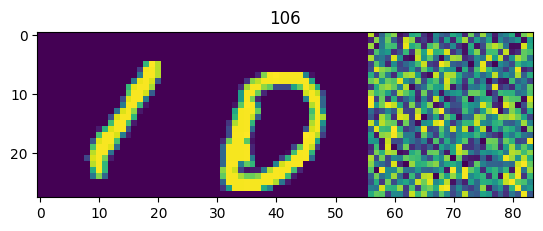

In [21]:
pick = np.random.randint(0, 2000)
plt.imshow(
    torch.concatenate(
        (xtrain[pick, 0, :, :], xcorr[pick, 0, :, :], xnoise[pick, 0, :, :]), 1
    )
)
plt.title(pick)

In [22]:
mnmodel = ConvVAE(nx=28, ny=28, latent_dim=20, img_channels=1).cuda()
mndet = OODdetector(mnmodel, refbb, valbb, batch_size=1000)
mndet.train()

h_dim 6272


Train Epoch:  34 train:  -447.97 test:  -443.83 : 100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


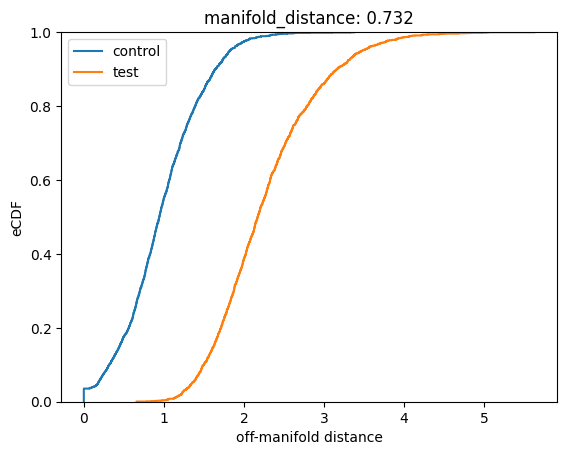

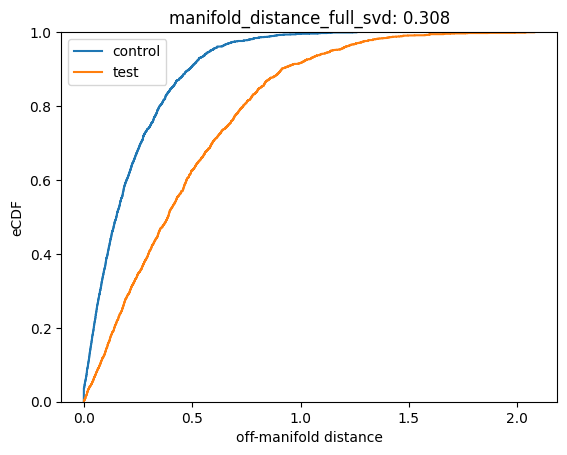

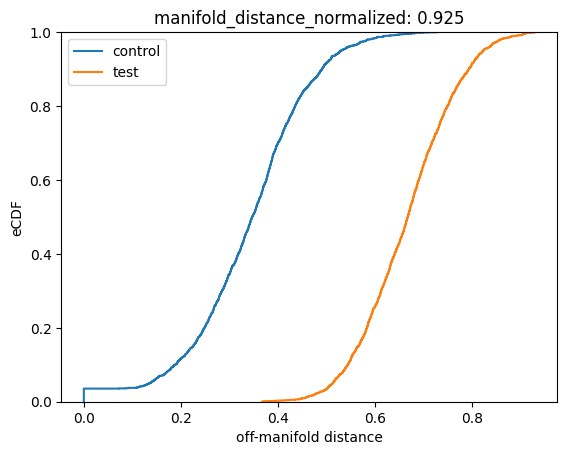

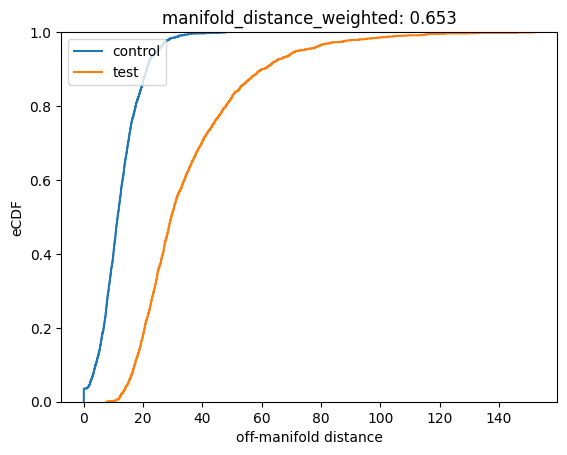

In [23]:
methods = [
    mndet.manifold_distance,
    mndet.manifold_distance_full_svd,
    mndet.manifold_distance_normalized,
    mndet.manifold_distance_weighted,
]
for method in methods:
    mndet.show_dists(xcorr, method=method)
    plt.title(plt.gca().get_title())
    plt.show()

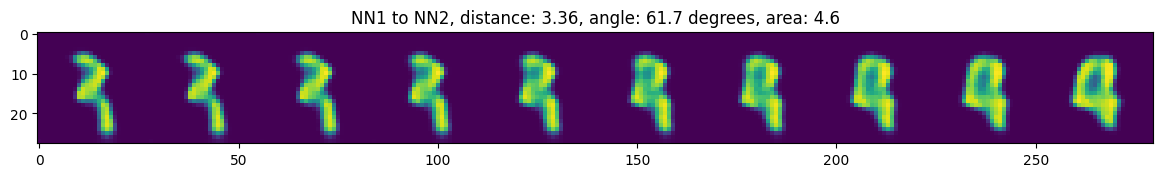

In [24]:
mndet.show_interpolated_images(xcorr[0], use_self=False)

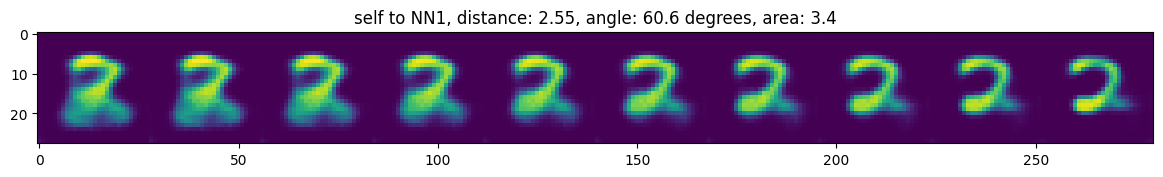

In [25]:
mndet.show_interpolated_images(mndet.prepare_naruto(), use_self=True)

Naruto is off-manifold by 0.64


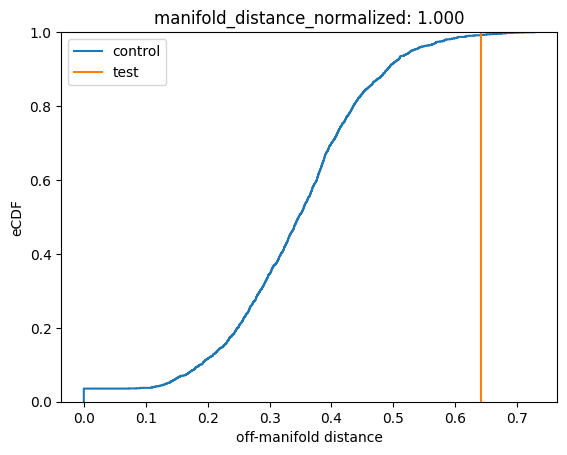

In [26]:
naruto_dist = mndet.manifold_distance_normalized(mndet.prepare_naruto())[0]
print(f'Naruto is off-manifold by {naruto_dist:.2f}')
mndet.show_dists(mndet.prepare_naruto(), mndet.manifold_distance_normalized)

In [27]:
from itertools import combinations


def test_ood(detector, FPfrac=None):
    # Here are my null hypothesis tests for OOD
    keys1 = ["spread", "xy", "ID", "1NN", "normdist"]
    meth1 = [
        detector.p_spread,
        detector.p_xy,
        detector.p_ID,
        detector.one_nn_distance_pval,
        detector.p_dist_normalized,
    ]
    val1results = [meth(detector.test_example) for meth in meth1]
    val1dict = dict(zip(keys1, val1results))

    FPfrac = 0.1 if FPfrac is None else FPfrac

    corrnames = ["shift", "spiky", "blur", "scale", "shear", "rotate"]
    corrlist = [corr1bb, corr2bb, corr3bb, corr4bb, corr5bb, corr6bb]

    for icorr, corrloader in enumerate(corrlist):
        for xcorr, _, _ in corrloader:
            break
        print(f"==============={corrnames[icorr]}=========================")
        corr1results = [meth(xcorr) for meth in meth1]
        corr1dict = dict(zip(keys1, corr1results))
        rlist = []
        for ncombo in range(1, len(keys1)):
            klist = [k for k in combinations(keys1, ncombo)]
            vlist = [v for v in combinations(val1results, ncombo)]
            results = dict({})
            for kc, vc in zip(klist, vlist):
                pv, pc = np.ones(len(xval)), np.ones(len(xcorr))
                rkey = ""
                for k, v in zip(kc, vc):
                    rkey = rkey + " " + k
                    pv *= val1dict[k]
                    pc *= corr1dict[k]
                cutoff = np.interp(FPfrac, np.linspace(0, 1, len(pv)), np.sort(pv))
                tp05 = np.interp(cutoff, np.sort(pc), np.linspace(0, 1, len(pc)))
                results.update({rkey: tp05})
            rlist.append(results)

        for i, d in enumerate(rlist):
            print(f"combination of {i+1} tests:")
            for k, v in d.items():
                print(f"{k}: {v:.2f}")
            print("")

In [28]:
test_ood(mndet, FPfrac=0.05)

===============shift=========================
combination of 1 tests:
 spread: 0.38
 xy: 0.34
 ID: 0.32
 1NN: 0.13
 normdist: 0.92

combination of 2 tests:
 spread xy: 0.50
 spread ID: 0.47
 spread 1NN: 0.23
 spread normdist: 0.87
 xy ID: 0.43
 xy 1NN: 0.27
 xy normdist: 0.90
 ID 1NN: 0.17
 ID normdist: 0.86
 1NN normdist: 0.53

combination of 3 tests:
 spread xy ID: 0.53
 spread xy 1NN: 0.33
 spread xy normdist: 0.84
 spread ID 1NN: 0.28
 spread ID normdist: 0.87
 spread 1NN normdist: 0.60
 xy ID 1NN: 0.29
 xy ID normdist: 0.87
 xy 1NN normdist: 0.61
 ID 1NN normdist: 0.55

combination of 4 tests:
 spread xy ID 1NN: 0.36
 spread xy ID normdist: 0.84
 spread xy 1NN normdist: 0.64
 spread ID 1NN normdist: 0.61
 xy ID 1NN normdist: 0.62

===============spiky=========================
combination of 1 tests:
 spread: 0.04
 xy: 0.02
 ID: 0.10
 1NN: 0.11
 normdist: 0.10

combination of 2 tests:
 spread xy: 0.03
 spread ID: 0.04
 spread 1NN: 0.04
 spread normdist: 0.06
 xy ID: 0.04
 xy 1NN: 0

<!-- 32605902. -->


# CIFAR-10


In [29]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=1000, shuffle=False, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=200, shuffle=False, num_workers=2
)

for Xcf_train, _ in trainloader:
    Xcf_train = Xcf_train.to(device)
    break

for Xcf_test, _ in testloader:
    Xcf_test = Xcf_test.to(device)
    break


cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [30]:

optmodel = ConvVAE(nx=32, ny=32, latent_dim=200).cuda()
optdet = OODdetector(optmodel, trainset, testset, batch_size=1000)

h_dim 8192


In [31]:
optdet.set_learning_rate(1e-3)
optdet.train(num_epochs=35)

Train Epoch:  34 train: -3784.28 test: -3839.82 : 100%|██████████| 35/35 [05:12<00:00,  8.93s/it]


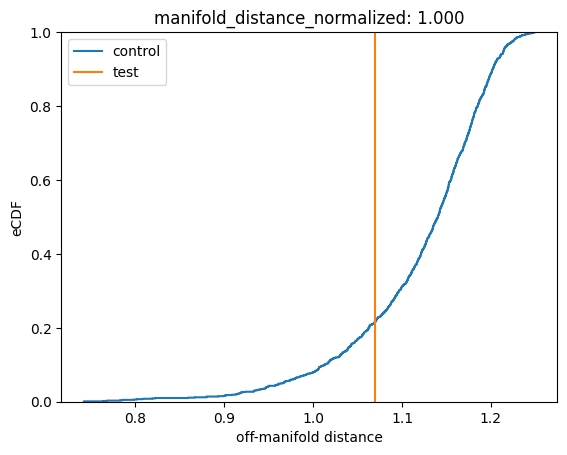

In [32]:
optdet.show_dists(optdet.prepare_naruto(), optdet.manifold_distance_normalized)

<class 'torch.Tensor'> cuda:0


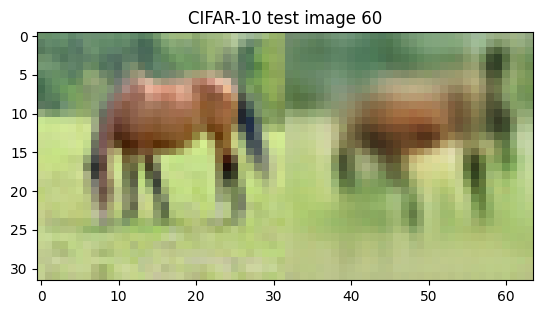

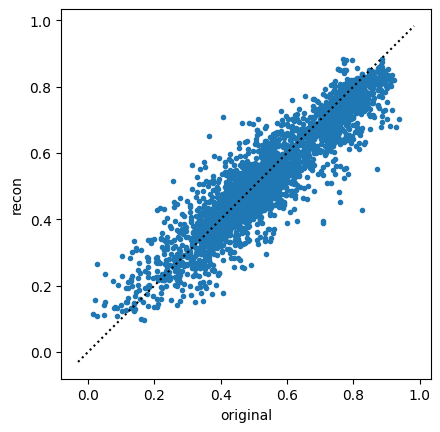

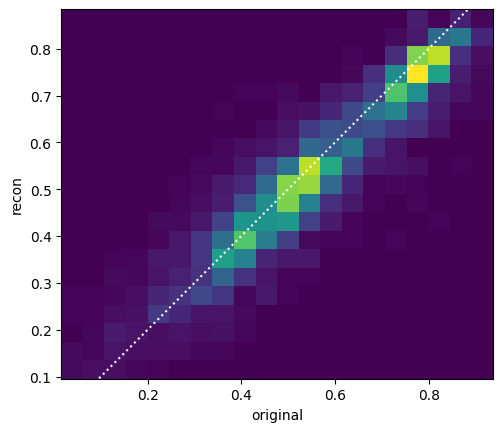

In [33]:
data2use = Xcf_test
recon = optdet.model(data2use)
print(type(recon[0]), recon[0].device)
out = recon[0].permute((0, 2, 3, 1)).detach().cpu()
orig = data2use.permute((0, 2, 3, 1)).detach().cpu()

outscale = (out - out.min()) / (out.max() - out.min())
out = torch.abs(out)
# pick = np.random.randint(0, len(orig))
pick = 60
plt.imshow(np.concatenate((orig[pick], out[pick]), axis=1))
plt.title(f'CIFAR-10 test image {pick}')
plt.show()

plt.plot(orig[pick].flatten(), out[pick].flatten(), ".")
plt.gca().set_aspect(1.0)
xall = plt.xlim()
plt.plot(xall, xall, "k:")
plt.xlabel("original")
plt.ylabel("recon")
plt.show()


plt.hist2d(orig[pick].flatten(), out[pick].flatten(), 20)
plt.gca().set_aspect(1.0)
plt.plot(xall, xall, "w:")
plt.xlabel("original")
plt.ylabel("recon")
plt.show()

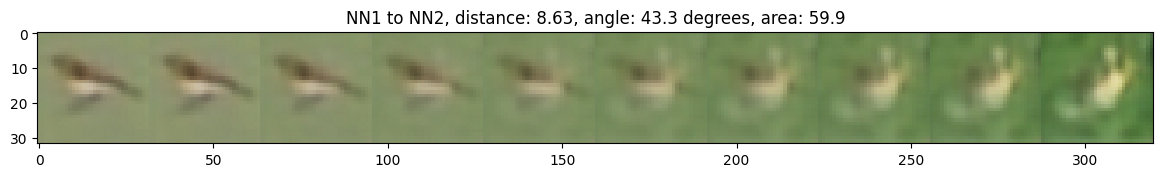

In [34]:
optdet.show_interpolated_images(Xcf_test[60:61])

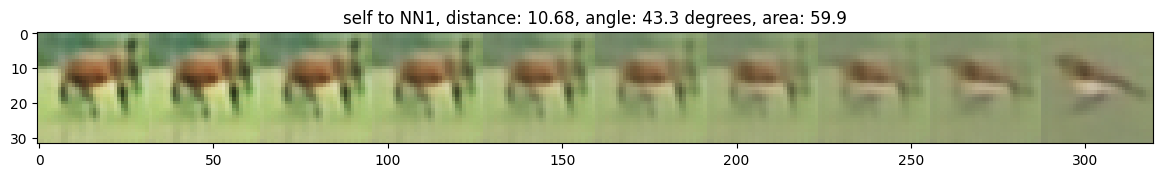

In [35]:
optdet.show_interpolated_images(Xcf_test[60:61], use_self=True)

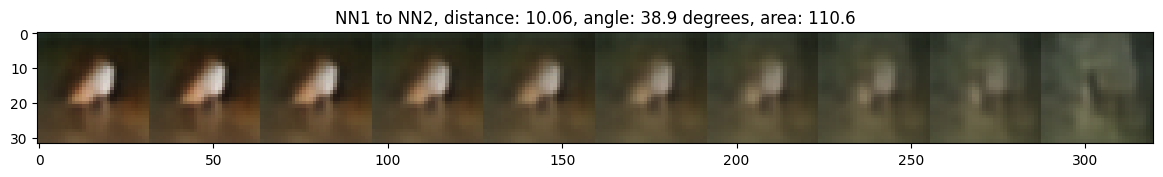

In [36]:
optdet.show_interpolated_images(optdet.prepare_naruto())

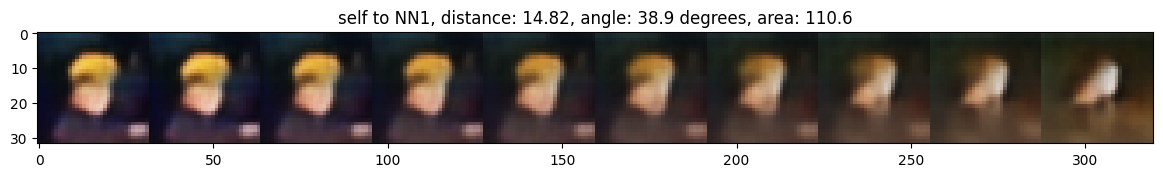

In [37]:
optdet.show_interpolated_images(optdet.prepare_naruto(), use_self=True)

In [38]:
optdet.detect_OOD(optdet.prepare_naruto())

array([False])

# Ships


First cell is minimal example checking for duplicate images bug


In [ ]:
import torch
import numpy as np

from torch.utils.data import DataLoader
# from dataeval.utils.data.datasets import ShipDataset

# workaround from Ryan 7_Mar-2025
train_ship = Ships(root="./data/", download=True, size=1800, unit_interval=True, channels="channels_first")
test_ship = Ships(root="./data/", download=True, size=2000, slice_back=True, unit_interval=True, channels="channels_first", balance=True)
# test_ship._data = test_ship._data[-200:] # workaround no longer needed 11-Mar-2025
# test_ship._targets = test_ship._targets[-200:]

trainbatch = next(iter(torch.utils.data.DataLoader(train_ship, batch_size=100)))[0]
testbatch = next(iter(torch.utils.data.DataLoader(test_ship, batch_size=100)))[0]
print('Testing that duplicates bug is gone....both tests should yield False.')
print(f'All odd-indexed image pairs in train and test are two copies of same image: {np.array([(trainbatch[2*i+1]==testbatch[2*i+1]).all() for i in range(50)]).all()}')
print(f'Some odd-indexed image pairs in train and test are two copies of same image: {np.array([(trainbatch[2*i+1]==testbatch[2*i+1]).all() for i in range(50)]).any()}')

Testing that duplicates bug is gone....both tests should yield False.
All odd-indexed image pairs in train and test are two copies of same image: False
Some odd-indexed image pairs in train and test are two copies of same image: False


In [55]:
shipmodel = ConvVAE(nx=80, ny=80, latent_dim=50).cuda()
shipdet = OODdetector(shipmodel, train_ship, test_ship, batch_size=100)

h_dim 51200


In [56]:
shipdet.set_learning_rate(1e-3)
shipdet.train()

100%|██████████| 20/20 [00:00<00:00, 23.07it/s]65 :  97%|█████████▋| 34/35 [01:27<00:02,  2.57s/it]
Train Epoch:  34 train: -30528.60 test: -24935.65 : 100%|██████████| 35/35 [01:27<00:00,  2.51s/it]


In [57]:
shipdet.manifold_distance(shipdet.prepare_naruto())

array([7.3726716])

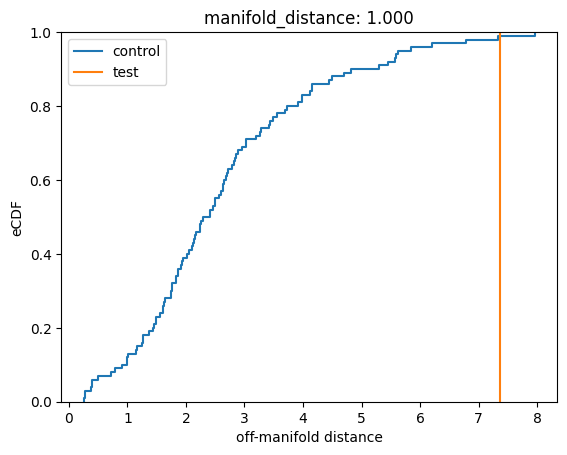

In [58]:
shipdet.show_dists(shipdet.prepare_naruto())

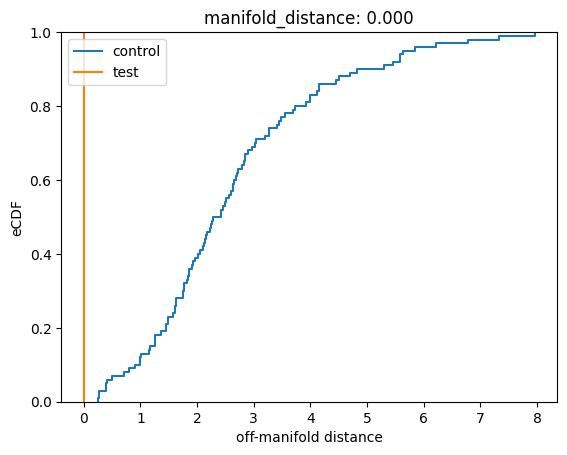

In [59]:
shipdet.show_dists(shipdet.training_example)

<class 'torch.Tensor'> cuda:0


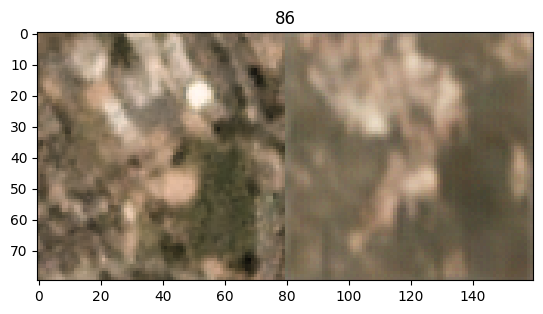

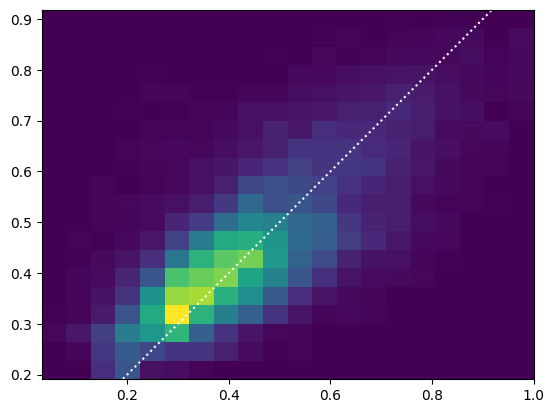

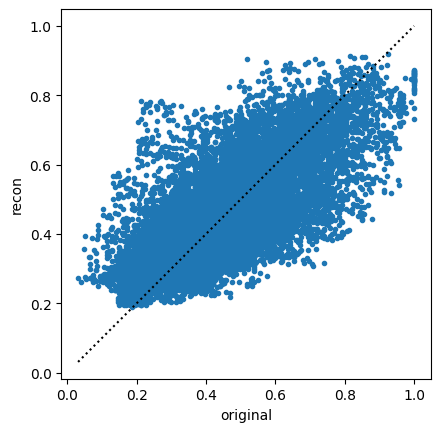

In [60]:
data2use = torch.as_tensor(next(iter(shipdet.test_loader))[0]).to(torch.float).to(shipdet.device)
recon = shipdet.model(data2use)
print(type(recon[0]), recon[0].device)
out = recon[0].permute((0, 2, 3, 1)).detach().cpu()
orig = data2use.permute((0, 2, 3, 1)).detach().cpu()

outscale = (out - out.min()) / (out.max() - out.min())
out = torch.abs(out)
pick = np.random.randint(0, len(orig))
# pick =  np.random.randint(0, len(orig))
plt.imshow(np.concatenate((orig[pick], out[pick]), axis=1))
plt.title(pick)
plt.show()

plt.hist2d(orig[pick].flatten(), out[pick].flatten(), 20)
plt.gca().set_aspect(1.0)
xall = plt.xlim()
plt.plot(xall, xall, "w:")
plt.show()

plt.plot(orig[pick].flatten(), out[pick].flatten(), ".")
plt.gca().set_aspect(1.0)
plt.plot(xall, xall, "k:")
plt.xlabel("original")
plt.ylabel("recon")
plt.show()




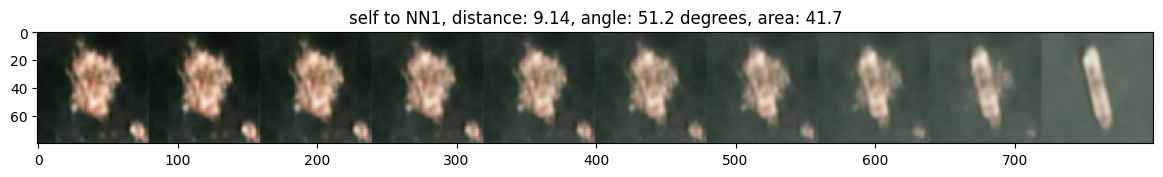

In [61]:
shipdet.show_interpolated_images(shipdet.prepare_naruto(), use_self=True)


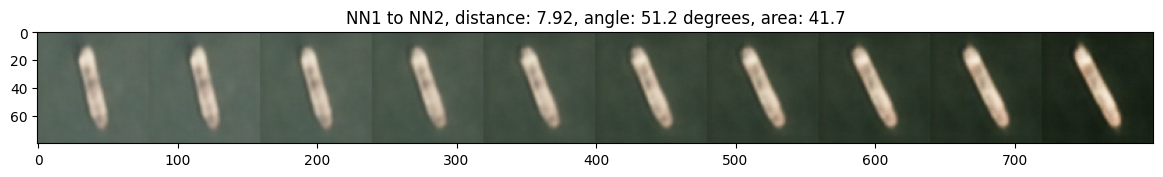

In [62]:
shipdet.show_interpolated_images(shipdet.prepare_naruto())


In [63]:
shipdet.detect_OOD(shipdet.prepare_naruto())

array([ True])

In [64]:
from vae_models import SigmaOptimalVAE
r50model = SigmaOptimalVAE(latent_dim = 50, input_height=80, input_width=80)

In [65]:
r50det = OODdetector(r50model, training_data=train_ship, test_data=test_ship)

In [66]:
r50det.train(num_epochs=1)

Train Epoch:   0 train:      nan test:      nan : 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


In [67]:
recon = r50det.model(trainbatch.to(torch.float).to(r50det.device))

In [68]:
r50det.manifold_dimension()

(np.float64(3.5966475360177763), np.float64(3.9589613341352567))

<class 'torch.Tensor'> cuda:0


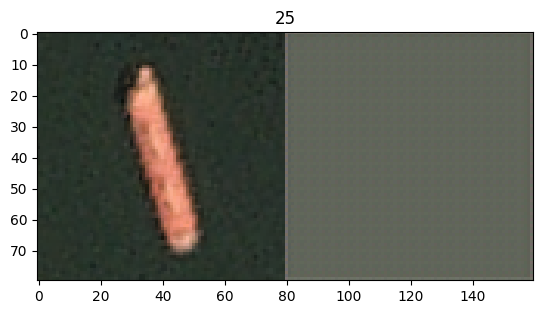

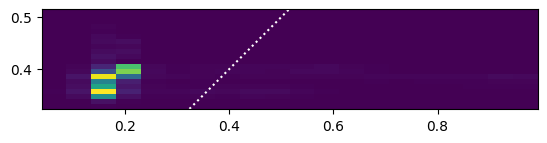

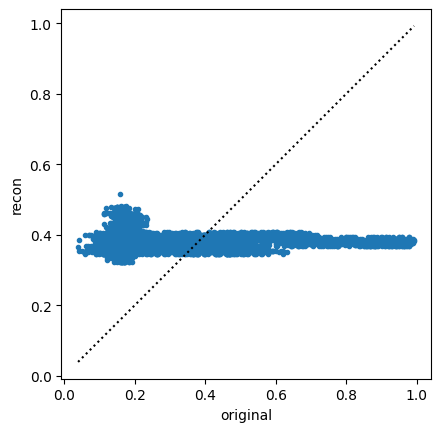

In [69]:
data2use = torch.as_tensor(next(iter(r50det.test_loader))[0]).to(torch.float).to(r50det.device)
r50det.model.eval()
recon = r50det.model(data2use)
print(type(recon[0]), recon[0].device)
out = recon[0].permute((0, 2, 3, 1)).detach().cpu()
orig = data2use.permute((0, 2, 3, 1)).detach().cpu()

outscale = (out - out.min()) / (out.max() - out.min())
out = torch.abs(out)
pick = np.random.randint(0, len(orig))
# pick =  np.random.randint(0, len(orig))
plt.imshow(np.concatenate((orig[pick], out[pick]), axis=1))
plt.title(pick)
plt.show()

plt.hist2d(orig[pick].flatten(), out[pick].flatten(), 20)
plt.gca().set_aspect(1.0)
xall = plt.xlim()
plt.plot(xall, xall, "w:")
plt.show()

plt.plot(orig[pick].flatten(), out[pick].flatten(), ".")
plt.gca().set_aspect(1.0)
plt.plot(xall, xall, "k:")
plt.xlabel("original")
plt.ylabel("recon")
plt.show()




In [70]:
torch.save(r50det.model.state_dict(), 'first_res50_ships.pth')

In [71]:
r50det.model.load_state_dict(torch.load('first_res50_ships.pth'))

/tmp/ipykernel_30608/3588451303.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  r50det.model.load_state_dict(torch.load('first_res50_ships.pth'))


<All keys matched successfully>

In [72]:
r50det.train(num_epochs=1)

Train Epoch:   0 train: -5731.18 test: -7065.58 : 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]
